# AN INTUITIVE INTRODUCTION TO GAUSSIAN PROCESSES
## Gaussian processes as the generalization of Gaussian probability distributions


by Sebastian T. Glavind, November, 2020

In [1]:
%matplotlib notebook

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
#

Python: 3.6.12
numpy: 1.19.1
matplotlib: 3.3.1


Rasmussen and Williams introduces Gaussian prossess (GPs) as

"*A Gaussian process is a generalization of the Gaussian probability distribution. Whereas a probability distribution describes random variables which are scalars or vectors (for  multivariate distributions), a stochastic process governs the properties of functions. Leaving mathematical sophistication aside, one can loosely think of a function as a very long vector, each entry in the vector specifying the function value $f(x)$ at a particular input $x$. It turns out, that although this idea is a little naive, it is surprisingly close what we need. Indeed, the question of how we deal computationally with these infinite dimensional objects has the most pleasant resolution imaginable: if you ask only for the properties of the function at a finite number of points, then inference in the Gaussian process will give you the same answer if you ignore the infinitely many other points, as if you would have taken them all into account!*"

<p style='text-align: right;'> - Gaussian processes for machine learning, p. 2 </p>

In this notebook, we will introduce GPs in this view, namely as a generalization of the Gaussian probability distribution and proceed to build up our intuition of GPs as representing distributions over functions. The introduction is based on Roberts et al.(2013).


***
Rasmussen, C. E. & Williams, C. K. (2006). Gaussian processes for machine learning. MIT press.

Roberts, S., Osborne, M., Ebden, M., Reece, S., Gibson, N., & Aigrain, S. (2013). Gaussian processes for time-series modelling. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 371(1984), 20110550.
***

## The Gaussian distribution

In the case of a single variable $x$, the Gaussian distribution, also known as the normal distribution, can be written as

$$ \mathcal{N}(x|\mu,\sigma^2) = \frac{1}{(2\pi\sigma^2)^{1/2}} \exp{ \left( -\frac{1}{2\sigma^2} (x - \mu)^2 \right)}, $$

where $\mu$ is the mean and $\sigma^2$ is the variance. For a D-dimensional vector $\mathbf{x}$, the multivariate Gaussian distribution takes the form

$$ \mathcal{N}(x|\boldsymbol\mu,\boldsymbol\Sigma) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\boldsymbol\Sigma|^{1/2}} \exp{ \left( - \frac{1}{2}(\mathbf{x}-\boldsymbol\mu)^T \boldsymbol\Sigma^{-1} (\mathbf{x}-\boldsymbol\mu) \right)}, $$

where $\boldsymbol\mu$ is the D-dimensional mean vector, $\boldsymbol\Sigma$ is the $D \times D$ covariance matrix, and $|\boldsymbol\Sigma|$ is the determinant of $\boldsymbol\Sigma$;

In [3]:
def univariate_normal(x, mean, variance):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

We start by considering a simple two-dimensional Gaussian distribution, which is defined for the variables $x_1$ and $x_2$ by a mean vector and a covariance matrix;

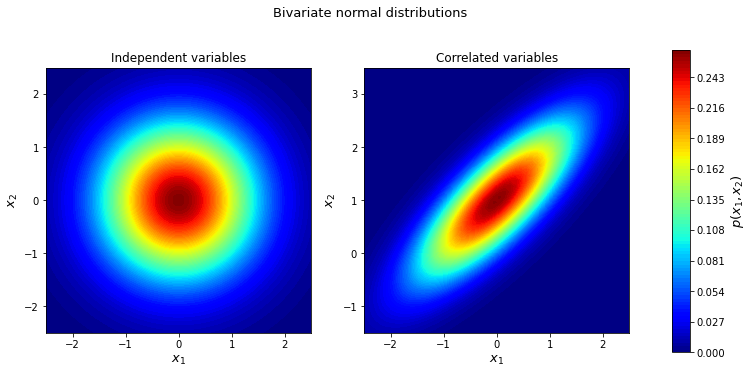

In [4]:
# Thanks to https://peterroelants.github.io/posts/multivariate-normal-primer/ #

# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_cov = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_cov, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap='jet')#, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[0.], [1.]])  # Mean
bivariate_cov = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_cov, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap='jet')#, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-2.5, 2.5, -1.5, 3.5])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()
#

We can easily sample from a multivariate Gaussian using the Cholesky decomposition as

In [5]:
np.random.seed(42)
# Sample from:
d = 2 # Number of dimensions
mean = np.matrix([[0.], [1.]])
cov = np.matrix([
    [1, 0.8], 
    [0.8, 1]
])

# Cholesky decomposition, i.e. covariance = L.dot(L.T), see e.g. Rasmussen and Williams (2006)
L = np.linalg.cholesky(cov)
# Sample X from standard normal
n = 50  # Samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

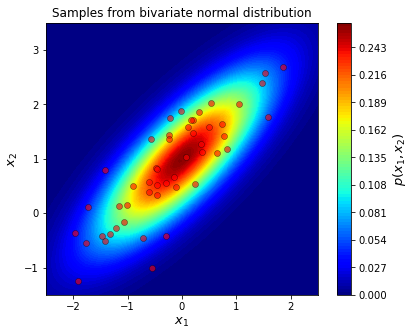

In [6]:
# Thanks to https://peterroelants.github.io/posts/multivariate-normal-primer/ #

# Plot the samples and the distribution
fig, ax = plt.subplots(figsize=(7, 5))
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, cov, d)
con = ax.contourf(x1, x2, p, 100, cmap='jet')#, cmap=cm.YlGnBu)
# Plot samples
ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.axis([-2.5, 2.5, -1.5, 3.5])
ax.set_aspect('equal')
ax.set_title('Samples from bivariate normal distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.show()
#

And we can plot the marginals by considering the mean vector and the diagonal terms of the covariance matrix (variances), as the marginals of a multivariate Gaussian distribution are also Gaussian distributed (see below). Note however that it is not a sufficient condition that the marginals are Gaussian for the joint distribution to be multivariate Gaussian!

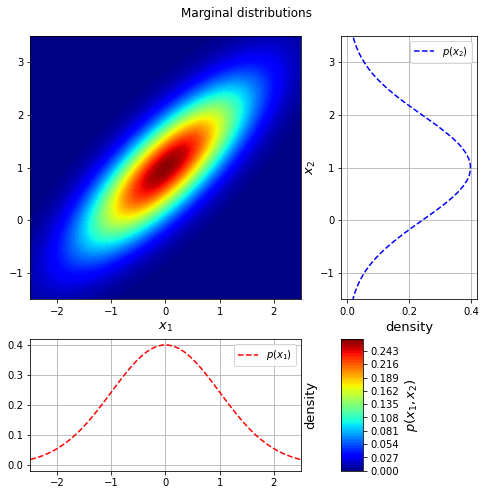

In [7]:
# Thanks to https://peterroelants.github.io/posts/multivariate-normal-primer/ #

# Plot the conditional distributions
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)
plt.suptitle('Marginal distributions', y=0.93)

# Plot surface on top left
ax1 = plt.subplot(gs[0])
x1, x2, p = generate_surface(mean, cov, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap='jet')#, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.yaxis.set_label_position('right')
ax1.axis([-2.5, 2.5, -1.5, 3.5])

# Plot x2
ax2 = plt.subplot(gs[1])
x2 = np.linspace(-5, 5, num=100)
px2 = univariate_normal(x2, mean[1,0], cov[1, 1])
# Plot univariate distribution
ax2.plot(px2, x2, 'b--', label=f'$p(x_2)$')
ax2.legend(loc=0)
ax2.set_xlabel('density', fontsize=13)
ax2.set_ylim(-1.5, 3.5)
ax2.grid()

# Plot x1
ax3 = plt.subplot(gs[2])
x1 = np.linspace(-5, 5, num=100)
px1 = univariate_normal(x1, mean[0,0], cov[0, 0])
# Plot univariate distribution
ax3.plot(x1, px1, 'r--', label=f'$p(x_1)$')
ax3.legend(loc=0)
ax3.set_ylabel('density', fontsize=13)
ax3.yaxis.set_label_position('right')
ax3.set_xlim(-2.5, 2.5)
ax3.grid()

# Clear axis 4 and plot colarbar in its place
ax4 = plt.subplot(gs[3])
ax4.set_visible(False)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('left', size='20%', pad=0.05)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.show()
#

Also conditional distributions of a multivariate Gaussian are Gaussians, e.g. if we condition on one of the variables in our two-dimensional example (observed), and the conditional, marginal distribution of the other variable is also Gaussian. The standard rules of conditioning Gaussian distributed random variables are lsited below;

$$ \mu_{a|b} = \mu_a + \Sigma_{ab}\Sigma_{bb}^{-1}(x_b - \mu_b) $$

$$ \Sigma_{a|b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}, $$

where

$$ 
\mu =\begin{bmatrix}
\mu_a\\
\mu_b
\end{bmatrix} 
\quad\text{and}\quad
\Sigma =\begin{bmatrix}
\Sigma_{aa}, \Sigma_{ab}\\
\Sigma_{ba}, \Sigma_{bb}
\end{bmatrix}. 
$$

Thus, because of the relationship between the variables implied by the covariance, knowledge of one variable reduces our uncertainty in the other;

In [8]:
# Calculate x|y
x2_condition = 1.  # To condition on y
mean_x1givenx2 = mean[0,0] + cov[0,1] * (1/cov[1,1]) * (x2_condition - mean[1,0])
cov_x1givenx2 = cov[0,0] - cov[0,1] * (1/cov[1,1]) * cov[1,0]

# Calculate y|x
x1_condition = -1.  # To condition on x
mean_x2givenx1 = mean[1,0] + (cov[1,0] * (1/cov[0,0]) * (x1_condition - mean[0,0]))
cov_x2givenx1 = cov[1,1] - cov[1,0] * (1/cov[0,0]) * cov[0,1]

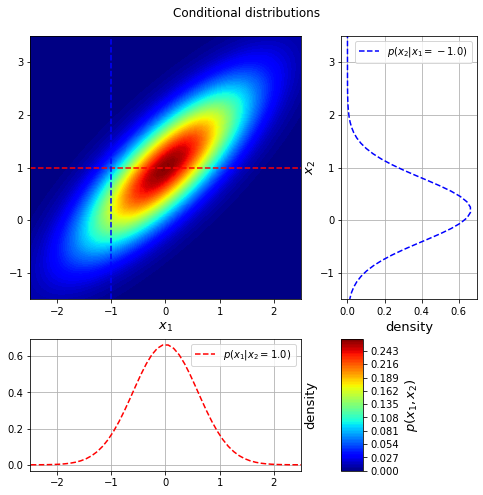

In [9]:
# Thanks to https://peterroelants.github.io/posts/multivariate-normal-primer/ #

# Plot the conditional distributions
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)
plt.suptitle('Conditional distributions', y=0.93)

# Plot surface on top left
ax1 = plt.subplot(gs[0])
x1, x2, p = generate_surface(mean, cov, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap='jet')
# y=1 that is conditioned upon
ax1.plot([-2.5, 2.5], [x2_condition, x2_condition], 'r--')
# x=-1. that is conditioned upon
ax1.plot([x1_condition, x1_condition], [-1.5, 3.5], 'b--')
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.yaxis.set_label_position('right')
ax1.axis([-2.5, 2.5, -1.5, 3.5])

# Plot x2|x1
ax2 = plt.subplot(gs[1])
x2x1 = np.linspace(-5, 5, num=100)
px2x1 = univariate_normal(x2x1, mean_x2givenx1, cov_x2givenx1)
# Plot univariate distribution
ax2.plot(px2x1, x2x1, 'b--', 
         label=f'$p(x_2|x_1={x1_condition:.1f})$')
ax2.legend(loc=0)
ax2.set_xlabel('density', fontsize=13)
ax2.set_ylim(-1.5, 3.5)
ax2.grid()

# Plot x1|x2
ax3 = plt.subplot(gs[2])
x1x2 = np.linspace(-5, 5, num=100)
px1x2 = univariate_normal(x1x2, mean_x1givenx2, cov_x1givenx2)
# Plot univariate distribution
ax3.plot(x1x2, px1x2, 'r--', 
         label=f'$p(x_1|x_2={x2_condition:.1f})$')
ax3.legend(loc=0)
ax3.set_ylabel('density', fontsize=13)
ax3.yaxis.set_label_position('right')
ax3.set_xlim(-2.5, 2.5)
ax3.grid()

# Clear axis 4 and plot colarbar in its place
ax4 = plt.subplot(gs[3])
ax4.set_visible(False)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('left', size='20%', pad=0.05)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.show()
#

## Gaussian processes

To link the considerations above to curvfitting using GPs, we now show the effect of conditioning using error bars, where the variables are aligned side-by-side. We first condider the case, where we condition on $x_1=-1$, as above, for comparrison;

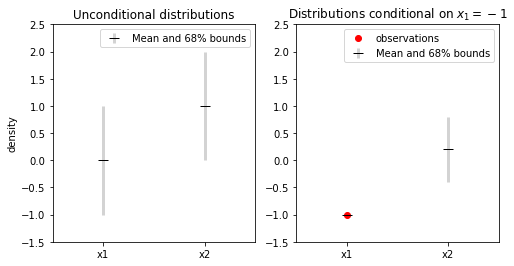

In [10]:
# Plot the conditional distributions
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 2)#, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)

# Unconditional distributions
ax1 = plt.subplot(gs[0])
yerr = mean
dyerr = np.sqrt(np.diag(cov))
ax1.errorbar(x = np.arange(2), y = yerr, yerr=dyerr, fmt='_', color='black', markersize='10', ecolor='lightgray', elinewidth=3, capsize=0, label='Mean and 68% bounds');
ax1.axis([-0.5, 1.5, -1.5, 2.5]);
ax1.set_xticks([0,1]) 
ax1.set_xticklabels(['x1','x2'])
ax1.set_ylabel('density')
ax1.title.set_text('Unconditional distributions')
ax1.legend(loc="upper right")

# Conditional distributions
ax2 = plt.subplot(gs[1])
yerr = np.array([x1_condition, mean_x2givenx1])
dyerr = np.array([0, np.sqrt(cov_x2givenx1)])
ax2.plot(0, x1_condition, 'or', label='observations')
ax2.errorbar(x = np.arange(2), y = yerr, yerr=dyerr, fmt='_', color='black', markersize='10', ecolor='lightgray', elinewidth=3, capsize=0, label='Mean and 68% bounds');
ax2.axis([-0.5, 1.5, -1.5, 2.5]);
ax2.set_xticks([0,1]) 
ax2.set_xticklabels(['x1','x2'])
ax2.title.set_text('Distributions conditional on $x_1=-1$')
ax2.legend(loc="upper right")
plt.show()
#

Now we may add additional dimensions to form a multivariate Gaussian over say 10 random variables. In this regard, we will assume the following mean vector and covariance matrix;

In [11]:
mean = np.zeros(10) # means
cov = np.array([[1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01, 2.05924246e-01, 8.46579886e-02, 2.85655008e-02, 7.91095973e-03, 1.79816666e-03, 3.35462628e-04],
                [9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01, 2.05924246e-01, 8.46579886e-02, 2.85655008e-02, 7.91095973e-03, 1.79816666e-03],
                [6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01, 2.05924246e-01, 8.46579886e-02, 2.85655008e-02, 7.91095973e-03],
                [4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01, 2.05924246e-01, 8.46579886e-02, 2.85655008e-02],
                [2.05924246e-01, 4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01, 2.05924246e-01, 8.46579886e-02],
                [8.46579886e-02, 2.05924246e-01, 4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01, 2.05924246e-01],
                [2.85655008e-02, 8.46579886e-02, 2.05924246e-01, 4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01, 4.11112291e-01],
                [7.91095973e-03, 2.85655008e-02, 8.46579886e-02, 2.05924246e-01, 4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01, 6.73638455e-01],
                [1.79816666e-03, 7.91095973e-03, 2.85655008e-02, 8.46579886e-02, 2.05924246e-01, 4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00, 9.05955191e-01],
                [3.35462628e-04, 1.79816666e-03, 7.91095973e-03, 2.85655008e-02, 8.46579886e-02, 2.05924246e-01, 4.11112291e-01, 6.73638455e-01, 9.05955191e-01, 1.00000000e+00]]) # covariance

# This shows how the above covariance matrix is generated using the squared-exponential kernel function
# def se_kern(x, y, sig_f, l_f):
#     sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) # reshape(-1,1): from one-dim. to two-dim. array.
#     K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
#     return(K)
# Xtrain = np.linspace(0,1,10).reshape(-1,1) # input
# amplitude = 1; length_scale=0.25
# cov = se_kern(Xtrain, Xtrain, amplitude, length_scale)

The covariance matrix is visualized below;

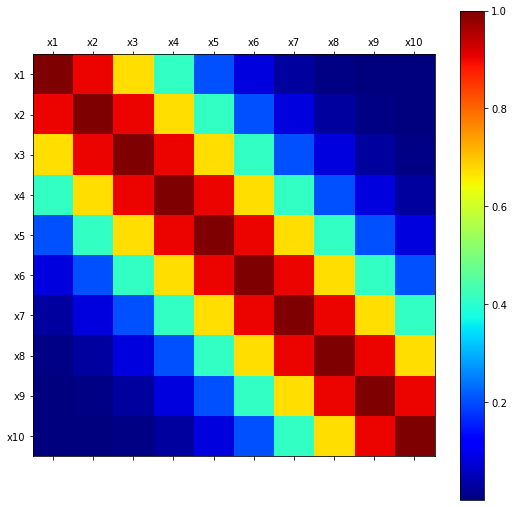

In [12]:
# plot covariance matrix
xlabs = [i + j for i, j in zip(['x']*10, map(str, np.arange(1,11,1)))] 
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
cax = ax.matshow(cov, cmap='jet')
fig.colorbar(cax)
ticks = np.arange(0,10,1);
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(xlabs);
ax.set_yticklabels(xlabs);
plt.show()
#

We may futher assume that we observe e.g. variable $x_2$, $x_6$ and $x_8$, and derive the conditional distribition for the remaining variables;

In [13]:
# Partitioning sets
index_b = np.array([1,5,7])
index_a = np.setdiff1d(np.arange(10), index_b)
mean_a = mean[index_a]
mean_b = mean[index_b]
cov_aa = cov[np.ix_(index_a, index_a)]
cov_bb = cov[np.ix_(index_b, index_b)]
cov_ab = cov[np.ix_(index_a, index_b)]
# Conditional distributions
xb = np.array([0.7, 0.6, 0.4]) # condition
mean_agivenb = mean_a + cov_ab.dot( np.linalg.inv(cov_bb) ).dot(xb - mean_b) # conditional mean
cov_agivenb = cov_aa - cov_ab.dot( np.linalg.inv(cov_bb) ).dot(cov_ab.T) # conditional cov

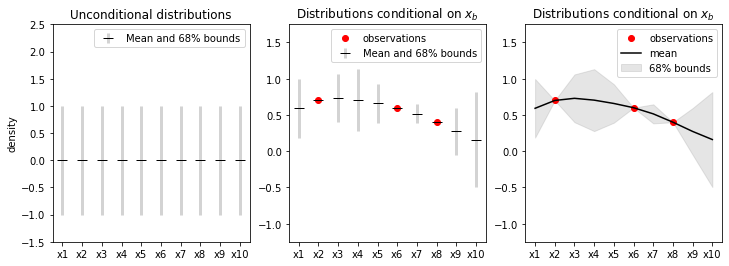

In [14]:
# Plot the conditional distributions
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)#, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)

# Unconditional distributions
ax1 = plt.subplot(gs[0])
yerr = mean
dyerr = np.sqrt(np.diag(cov))
ax1.errorbar(x = np.arange(10), y = yerr, yerr=dyerr, fmt='_', color='black', markersize='10', ecolor='lightgray', elinewidth=3, capsize=0, label='Mean and 68% bounds');
ax1.axis([-0.5, 9.5, -1.5, 2.5]);
ax1.set_xticks(range(10)) 
ax1.set_xticklabels(xlabs)
ax1.set_ylabel('density')
ax1.title.set_text('Unconditional distributions')
ax1.legend(loc="upper right")

# Conditional distributions
ax2 = plt.subplot(gs[1])
yerr = np.zeros(10); yerr[index_a] = mean_agivenb; yerr[index_b] = xb
dyerr = np.zeros(10); dyerr[index_a] = np.sqrt(np.diag(cov_agivenb));
ax2.plot(index_b, xb, 'or', label='observations')
ax2.errorbar(x = np.arange(10), y = yerr, yerr=dyerr, fmt='_', color='black', markersize='10', ecolor='lightgray', elinewidth=3, capsize=0, label='Mean and 68% bounds');
ax2.axis([-0.5, 9.5, -1.25, 1.75]);
ax2.set_xticks(range(10)) 
ax2.set_xticklabels(xlabs)
ax2.title.set_text('Distributions conditional on $x_b$')
ax2.legend(loc="upper right")

# Conditional distributions (continuous)
ax3 = plt.subplot(gs[2])
ax3.plot(index_b, xb, 'or', label='observations')
ax3.plot(np.arange(10), yerr, '-', color='black', label='mean')
ax3.fill_between(np.arange(10), yerr - dyerr, yerr + dyerr, color='gray', alpha=0.2, label='68% bounds')
ax3.axis([-0.5, 9.5, -1.25, 1.75]);
ax3.set_xticks(range(10)) 
ax3.set_xticklabels(xlabs)
ax3.title.set_text('Distributions conditional on $x_b$')
ax3.legend(loc="upper right")
plt.show()
#

The right plot looks a lot like curvfitting; notice that the only difference between the middle plot and the right plot is that we have connected the mean points and the error bars. In principle, we can keep adding dimensions, and as we approach $D \to \inf$ in which the locations of the $x_i$'s are infinitely dense (here, on the real line), the infinite joint distribution over them all is equivalent to a distribution over a function space. This is where Gaussian processes come into the picture, as it provides a framework of formulating and working with this distribution over functions, see below.

## Distributions over functions

Now that we have an understanding of how GPs gereralizes the Gaussian distribution, let's consider how they may be used in practice for surrogate modeling. In this regard, we will study the typical regression setting, i.e.

$$ y = f(x) + \epsilon, $$

where $f$ is a (unknown) function mapping inputs ($x$) to outputs ($y$) and $\epsilon$ is an additive noise process, which is typically assumed to be Gaussian white noise, i.e. $\epsilon \sim \mathcal{N}(0,\sigma^2)$. Having observed some data $\mathcal{D}=\{ x[n], y[n] \}_{n=1}^N$, our objective is to determine the functional relationship.

Based on the following data set, we can use different modeling approaches to represent the functional form of $f$.

In [41]:
np.random.seed(42)
std_y = 0.025
x = np.arange(0,2.5,0.5); nX = len(x);
y = np.array([0, 0.04, 0.11, 0.15, 0.21]) + np.random.normal(0,std_y,nX)

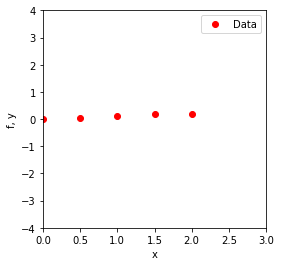

In [54]:
def plot_training_data(x,y):
    plt.plot(x,y,'or')
    plt.xlabel('x')
    plt.ylabel('f, y')
    plt.xlim([0,3])
    plt.ylim([-4,4])

plt.figure(figsize=(4, 4))
plot_training_data(x,y)
plt.legend(['Data'])
plt.show()

### Classic (frequentistic) polynomial regression

We assume that $f$ has the following parametric form

$$f(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3.$$

See my tutorial on [*Linear regression*](https://nbviewer.jupyter.org/github/SebastianGlavind/PhD-study/blob/master/Linear-regression/LinReg.ipynb) for the matematical details on how to conduct inference in this setting. 

In [43]:
def design_matrix(x):
    nX = len(x)
    XX = np.stack([ np.ones(nX), x, x**2, x**3]).T # 3. degree polynomial
    return(XX)

XX = design_matrix(x);
Wols = np.linalg.pinv(XX).dot(y)

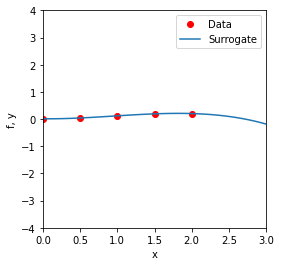

In [53]:
x_plot = np.linspace(0, 3, 100)
XX_plot = design_matrix(x_plot)
f_plot = np.dot(XX_plot,Wols)

plt.figure(figsize=(4, 4))
plot_training_data(x,y)
plt.plot(x_plot,f_plot)
plt.legend(['Data', 'Surrogate'])
plt.show()

### Bayesian polynomial regression

We again assume that $f$ has the following parametric form

$$f(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3.$$

See my tutorial on [*Linear regression*](https://nbviewer.jupyter.org/github/SebastianGlavind/PhD-study/blob/master/Linear-regression/LinReg.ipynb) for the matematical details on how to conduct inference in this setting.  

In [45]:
# Assume Jeffreys prior
V_w_pos = np.linalg.inv( XX.T.dot(XX) )
mu_w_pos = V_w_pos.dot(XX.T).dot(y)
Sig_w_pos = V_w_pos * std_y**2

# Sample weights
np.random.seed(100)
Wbayes = np.random.multivariate_normal(mean=mu_w_pos, cov=Sig_w_pos, size=50)

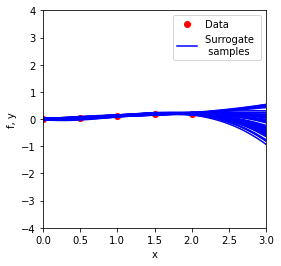

In [52]:
fbayes_plot = np.dot(XX_plot,Wbayes.T)

plt.figure(figsize=(4, 4))
plot_training_data(x,y)
plt.plot(x_plot,fbayes_plot,'-b')
plt.legend(['Data', 'Surrogate \n samples'])
plt.show()

### Gaussian process regression

We now assume that $f$ is a non-linear, non-parametric function with a GP prior:

$$\mathcal{GP}(m(x),k(x,x')),$$

where $m(x)$ is a mean function, which is assumed to be the zero vector in this tutorial, and $k(x,x')$ is a kernel function, which is assumed to be the squared-exponenial in this tutorial. See my tutorial on [*Gaussian process regression*](https://nbviewer.jupyter.org/github/SebastianGlavind/PhD-study/blob/master/Gaussian-processes/GPR.ipynb) for the matamatical details on how to conduct inference for this model.

In [47]:
# Squared-exponential kernel
def se_kern(x, y, sig_f, l_f):
    x = x.reshape(-1,1); y = y.reshape(-1,1) # reshape(-1,1): from one-dim. to two-dim. array.
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) 
    K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
    return(K)

In [48]:
def sample_posterior(x, y, std_y, xte, amplitude, length_scale):
    nX = len(x)
    nXte = len(xte)
    eps = 1e-6
    
    # Compute Gram matrix
    K = se_kern(x, x, amplitude, length_scale)
    K_s = se_kern(x, xte, amplitude, length_scale)
    K_ss = se_kern(xte, xte, amplitude, length_scale)

    # Apply the kernel function to our training points
    L = np.linalg.cholesky(K + np.eye(nX)*std_y**2)

    # predictive mean
    alp_m = np.linalg.solve(L.T,np.linalg.solve(L, y))
    mu_pos = np.dot(K_s.T, alp_m)

    # predictive variance
    vv_m = np.linalg.solve(L,K_s)
    cov_pos = K_ss - vv_m.T.dot(vv_m)

    # Draw samples from the posterior at our test points.
    n_samp_pos = 50
    L_pos = np.linalg.cholesky(cov_pos + eps*np.eye(nXte))
    f_pos = mu_pos.reshape(-1,1) + np.dot(L_pos, np.random.normal(size=(nXte,n_samp_pos)))
    return(mu_pos, cov_pos, f_pos)

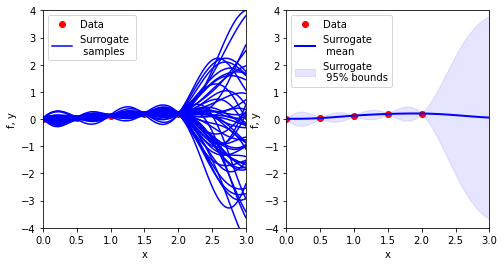

In [51]:
# Kernel hyper-parameters
amplitude = 2; length_scale=0.6

# Posterior and posterior samples
np.random.seed(100)
mu_gp_plot, cov_gp_plot, fgp_plot = sample_posterior(x, y, std_y, x_plot, amplitude, length_scale)
std_gp_plot = np.sqrt(np.diag(cov_gp_plot))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_training_data(x,y)
plt.plot(x_plot,fgp_plot,'-b')
plt.legend(['Data', 'Surrogate \n samples'], loc='upper left')

plt.subplot(1,2,2)
plot_training_data(x,y)
plt.fill_between(x=x_plot, y1=mu_gp_plot-2*std_gp_plot, y2=mu_gp_plot+2*std_gp_plot, alpha=0.1, color='blue');
plt.plot(x_plot, mu_gp_plot, '-b', lw=2)
plt.legend(['Data', 'Surrogate \n mean', 'Surrogate \n 95% bounds'], loc='upper left')
plt.show()

Passing through the model representations from the classical polynomial regression to the Bayesian polynomial regression and finally to the GP regression, we see a gradual increase in model complexity, which leads to added flexibility in the model representations. First, the classical polynomial regression fits the data well in the range of the data, but it does not give an indication of model credibility outside the range of the data. Second, we may consider a family of curves (3. degree polynomials) that explains the data equally well, by introducing uncertainty on the weights in the Bayesian polynomial regression. This leads to a distribution over curves, which gives an indication of the credibility of the model inside as well as outside the range of the observed data. Third, if we now introduce uncertainty on the functional form as well, thus we do not adhere to 3. degree polynomials only but consider all possible model representations, we may define a distribution over functions using a GP. In this case, we observe significant variability between the candidate curves both within and (especially) outside the range of the data, and the density of curves at any given point indicates the plausability of a functional value at that point.